In [1]:
import xarray as xr
import glob
import intake
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
ssp_colors = {"evaluation":"k",
              "historical":"grey",
              "ssp585":(149/255,27/255,30/255),
              "ssp370":(231/255,29/255,37/255),
              "ssp245":(247/255,148/255,32/255),
              "ssp126":(23/255,60/255,102/255),
              "ssp119":(0/255,173/255,207/255),}

In [3]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

from dask.diagnostics import ProgressBar
# ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=14)
client

<Client: 'tcp://127.0.0.1:46617' processes=14 threads=28, memory=18.00 GiB>

In [4]:
cat_name = "barpa"
col = intake.open_esm_datastore(f"/g/data/lp01/collections/py3.9_dev/nci-{cat_name}.json")

# Edit this cell
var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]
table_id = "6hr"
scenarios = ["historical","ssp126", "ssp370", "ssp585", "evaluation"]

# change this query to select a subset of the data you are interested in
query = dict(variable_id = var_list[0],
             table_id = table_id,
             experiment_id = scenarios,
            )

cat = col.search(**query)
cat.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                                                      [v20231001]
variable_id                                                      [ua200]
table_id                                                           [6hr]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [17]:
var_list = list(col.unique()["variable_id"])

In [4]:
cat_df_max = cat.df.groupby(["variable_id", "experiment_id", "source_id", "member_id"]).max().reset_index()
cat_df_max["index"] = cat_df_max.experiment_id + "_" + cat_df_max.source_id + "_" + cat_df_max.member_id
cat_df_max = cat_df_max.set_index("index")
cat_df_max

variable_id experiment_id      source_id  \
index                                                                        
evaluation_ERA5_r1i1p1f1                ua200    evaluation           ERA5   
historical_ACCESS-CM2_r4i1p1f1          ua200    historical     ACCESS-CM2   
historical_ACCESS-ESM1-5_r6i1p1f1       ua200    historical  ACCESS-ESM1-5   
historical_CESM2_r11i1p1f1              ua200    historical          CESM2   
historical_CMCC-ESM2_r1i1p1f1           ua200    historical      CMCC-ESM2   
historical_EC-Earth3_r1i1p1f1           ua200    historical      EC-Earth3   
historical_MPI-ESM1-2-HR_r1i1p1f1       ua200    historical  MPI-ESM1-2-HR   
historical_NorESM2-MM_r1i1p1f1          ua200    historical     NorESM2-MM   
ssp126_ACCESS-CM2_r4i1p1f1              ua200        ssp126     ACCESS-CM2   
ssp126_ACCESS-ESM1-5_r6i1p1f1           ua200        ssp126  ACCESS-ESM1-5   
ssp126_CESM2_r11i1p1f1                  ua200        ssp126          CESM2   
ssp126_CMCC-ESM2_r1i1p1f1               ua200        ssp126      CMCC-ESM2   
ssp126_EC-Earth3_r1i1p1f1               ua200        ssp126      EC-Earth3   
ssp126_MPI-ESM1-2-HR_r1i1p1f1           ua200        ssp126  MPI-ESM1-2-HR   
ssp126_NorESM2-MM_r1i1p1f1              ua200        ssp126     NorESM2-MM   
ssp370_ACCESS-CM2_r4i1p1f1              ua200        ssp370     ACCESS-CM2   
ssp370_ACCESS-ESM1-5_r6i1p1f1           ua200        ssp370  ACCESS-ESM1-5   
ssp370_CESM2_r11i1p1f1                  ua200        ssp370          CESM2   
ssp370_CMCC-ESM2_r1i1p1f1               ua200        ssp370      CMCC-ESM2   
ssp370_EC-Earth3_r1i1p1f1               ua200        ssp370      EC-Earth3   
ssp370_MPI-ESM1-2-HR_r1i1p1f1           ua200        ssp370  MPI-ESM1-2-HR   
ssp370_NorESM2-MM_r1i1p1f1              ua200        ssp370     NorESM2-MM   
ssp585_ACCESS-CM2_r4i1p1f1              ua200        ssp585     ACCESS-CM2   
ssp585_EC-Earth3_r1i1p1f1               ua200        ssp585      EC-Earth3   

                                   member_id activity_id institution_id  \
index                                                                     
evaluation_ERA5_r1i1p1f1            r1i1p1f1     BARPA-R            BOM   
historical_ACCESS-CM2_r4i1p1f1      r4i1p1f1     BARPA-R            BOM   
historical_ACCESS-ESM1-5_r6i1p1f1   r6i1p1f1     BARPA-R            BOM   
historical_CESM2_r11i1p1f1         r11i1p1f1     BARPA-R            BOM   
historical_CMCC-ESM2_r1i1p1f1       r1i1p1f1     BARPA-R            BOM   
historical_EC-Earth3_r1i1p1f1       r1i1p1f1     BARPA-R            BOM   
historical_MPI-ESM1-2-HR_r1i1p1f1   r1i1p1f1     BARPA-R            BOM   
historical_NorESM2-MM_r1i1p1f1      r1i1p1f1     BARPA-R            BOM   
ssp126_ACCESS-CM2_r4i1p1f1          r4i1p1f1     BARPA-R            BOM   
ssp126_ACCESS-ESM1-5_r6i1p1f1       r6i1p1f1     BARPA-R            BOM   
ssp126_CESM2_r11i1p1f1             r11i1p1f1     BARPA-R            BOM   
ssp126_CMCC-ESM2_r1i1p1f1           r1i1p1f1     BARPA-R            BOM   
ssp126_EC-Earth3_r1i1p1f1           r1i1p1f1     BARPA-R            BOM   
ssp126_MPI-ESM1-2-HR_r1i1p1f1       r1i1p1f1     BARPA-R            BOM   
ssp126_NorESM2-MM_r1i1p1f1          r1i1p1f1     BARPA-R            BOM   
ssp370_ACCESS-CM2_r4i1p1f1          r4i1p1f1     BARPA-R            BOM   
ssp370_ACCESS-ESM1-5_r6i1p1f1       r6i1p1f1     BARPA-R            BOM   
ssp370_CESM2_r11i1p1f1             r11i1p1f1     BARPA-R            BOM   
ssp370_CMCC-ESM2_r1i1p1f1           r1i1p1f1     BARPA-R            BOM   
ssp370_EC-Earth3_r1i1p1f1           r1i1p1f1     BARPA-R            BOM   
ssp370_MPI-ESM1-2-HR_r1i1p1f1       r1i1p1f1     BARPA-R            BOM   
ssp370_NorESM2-MM_r1i1p1f1          r1i1p1f1     BARPA-R            BOM   
ssp585_ACCESS-CM2_r4i1p1f1          r4i1p1f1     BARPA-R            BOM   
ssp585_EC-Earth3_r1i1p1f1           r1i1p1f1     BARPA-R            BOM   

                                     version table_id 

In [5]:
# indices for evaluation, historical and future groups. These will share time ranges
i_evaluation = cat_df_max.loc[cat_df_max["experiment_id"].isin(["evaluation"])].index
i_historical = cat_df_max.loc[cat_df_max["experiment_id"].isin(["historical"])].index
i_future = cat_df_max.loc[cat_df_max["experiment_id"].isin(["ssp126", "ssp370", "ssp585"])].index

In [6]:
list_evaluation = ['evaluation_ERA5_r1i1p1f1']

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   # 'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

list_ssp126 = [
                 # 'ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 # 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',
              ]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 # 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',
              ]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

In [7]:
# windspeed percentiles for -60 to -30. for era5 1980-1999
p95, p99, p999 = (59.650381757029564, 73.46444525842983, 86.41072482237834)

In [8]:
# turbulence_index = "windspeed"

# for run in i_evaluation:
#     experiment_id, source_id, member_id = run.split("_")
#     print(f"{experiment_id}, {source_id}, {member_id}")
#     time_range = np.arange(1980,1982+1)
    
#     filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
#      for year in time_range]
#     ds=xr.open_dataset(filelist[0])

In [9]:
def calc_freq_season(run, 
                     turbulence_index = "windspeed",
                     threshold = p99, 
                     start_year = 1980,
                     end_year = 1999,
                     compute = False):
    """Calculate the season frequency above a specified threshold for each season.
    Returns delayed dataset"""
    print(run)
    experiment_id, source_id, member_id = run.split("_")
    time_range = np.arange(start_year-1,end_year+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds,):
        ds = (ds.sel(lat=slice(-60,-30),)>threshold).mean(["lat", "lon"]).resample({"time":"ME"},).mean(["time"])
        return ds
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", concat_dim="time",
                           chunks = {"time":200, "lat":-1, "lon":-1},
                           # errors="warn",
                          ).assign_coords({"run":run})
    
    ds = ds.chunk({ "time":-1})
    
    # turn into seasonal data
    ds = ds.resample({"time":"QS-DEC"}).mean().sel({"time":slice(str(start_year),str(end_year))}) 
    ds = ds.rename({"windspeed": f"freq_above_threshold_{turbulence_index}"})
    
    if compute:
        ds = ds.compute()
    
    return ds
    

In [10]:
# ds["freq_above_threshold_windspeed"].loc[ds.time.dt.season=="DJF"].plot()
# ds["freq_above_threshold_windspeed"].loc[ds.time.dt.season=="MAM"].plot()
# ds["freq_above_threshold_windspeed"].loc[ds.time.dt.season=="JJA"].plot()
# ds["freq_above_threshold_windspeed"].loc[ds.time.dt.season=="SON"].plot()

In [11]:
%%time
delayed_results = {}

turbulence_index = "windspeed"
threshold = p99

# past
start_year = 1980
end_year = 2014

for run in list_evaluation:
    delayed_results[run] = calc_freq_season(run, 
                                             turbulence_index = turbulence_index,
                                             threshold = p99, 
                                             start_year = start_year,
                                             end_year = end_year,)

# past
start_year = 1980
end_year = 2014

for run in list_historical:
    delayed_results[run] = calc_freq_season(run, 
                                             turbulence_index = turbulence_index,
                                             threshold = p99, 
                                             start_year = start_year,
                                             end_year = end_year,)

# future
start_year = 2015+1
end_year = 2100

for run in list_ssp126 + list_ssp370 + list_ssp585:
    delayed_results[run] = calc_freq_season(run, 
                                             turbulence_index = turbulence_index,
                                             threshold = p99, 
                                             start_year = start_year+1,
                                             end_year = end_year,)


evaluation_ERA5_r1i1p1f1
historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp370_NorESM2-MM_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 1min 20s, sys: 41.4 s, total: 2min 1s
Wall time: 2min 24s


In [12]:
%%time
results = []
for run in list_evaluation + list_historical +list_ssp126 + list_ssp370 + list_ssp585:
     print(run)
     results.append(delayed_results[run].compute())
ds_results = xr.concat(results, dim="run")
ds_results    

evaluation_ERA5_r1i1p1f1
historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 15min 57s, sys: 5min 28s, total: 21min 25s
Wall time: 44min 8s


<xarray.Dataset> Size: 83kB
Dimensions:                         (run: 20, time: 476)
Coordinates:
  * time                            (time) object 4kB 1980-03-01 00:00:00 ......
    pressure                        int64 8B 250
  * run                             (run) <U33 3kB 'evaluation_ERA5_r1i1p1f1'...
Data variables:
    freq_above_threshold_windspeed  (run, time) float64 76kB 0.00466 ... 0.00...

In [14]:
ds_results = ds_results.rename({"freq_above_threshold_windspeed": "freq_above_p99_windspeed"})
ds_results.to_netcdf("/scratch/v46/gt3409/timeseries_windspeed_mog_p99_season.nc")

In [15]:
ds_results.to_netcdf("/scratch/v46/gt3409/timeseries_windspeed_freq_above_p99_season.nc")

In [16]:
ds_results = xr.open_dataset("/scratch/v46/gt3409/timeseries_windspeed_freq_above_p99_season.nc")

In [65]:
df_jja[[var]].rolling(window=window_size, center=True).mean()

freq_above_p99_windspeed
1                          NaN
5                          NaN
9                          NaN
13                         NaN
17                         NaN
...                        ...
9501                       NaN
9505                       NaN
9509                       NaN
9513                       NaN
9517                       NaN

[2380 rows x 1 columns]

In [82]:
df_djf = df.loc[df.time.dt.month.isin([12, 1, 2])]
df_mam = df.loc[df.time.dt.month.isin([3, 4, 5])]
df_jja = df.loc[df.time.dt.month.isin([6, 7, 8])]
df_son = df.loc[df.time.dt.month.isin([9, 10, 11])]



In [83]:
window_size = 21
df_djf[f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()
df_mam[f"rolling_{window_size}y"] = df_mam[var].rolling(window=window_size, center=True).mean()
df_jja[f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()
df_son[f"rolling_{window_size}y"] = df_son[var].rolling(window=window_size, center=True).mean()


/jobfs/149558643.gadi-pbs/ipykernel_702242/3882102126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_djf[f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/3882102126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mam[f"rolling_{window_size}y"] = df_mam[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/3882102126.py:4: SettingWithCopyWarning: 
A value is trying to be

<Axes: xlabel='time', ylabel='rolling_21y'>

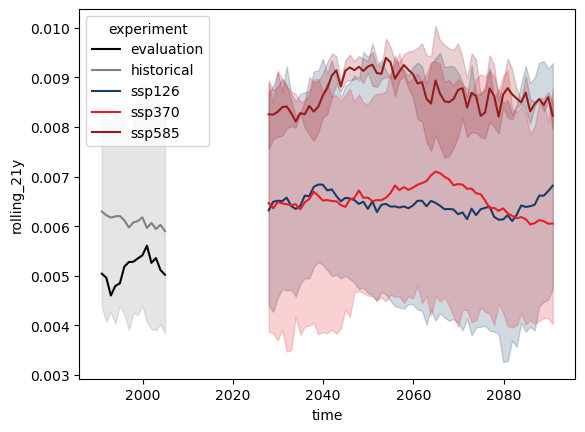

In [84]:
sns.lineplot(df_djf, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

<Axes: xlabel='time', ylabel='rolling_21y'>

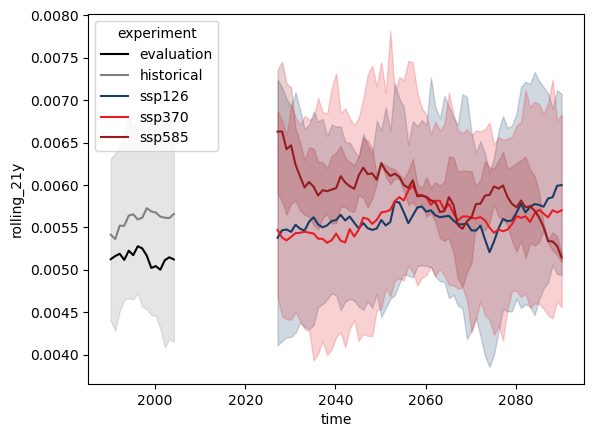

In [85]:
sns.lineplot(df_mam, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

<Axes: xlabel='time', ylabel='rolling_21y'>

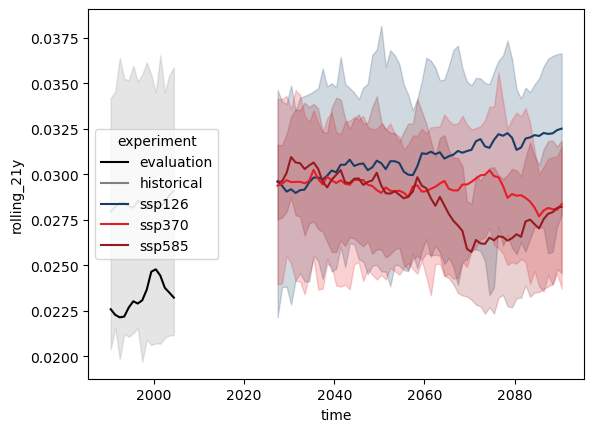

In [86]:
sns.lineplot(df_jja, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

<Axes: xlabel='time', ylabel='rolling_21y'>

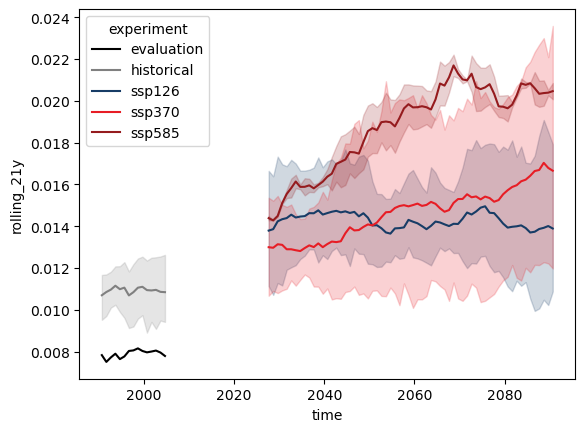

In [88]:
sns.lineplot(df_son, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

In [68]:
var =  "freq_above_p99_windspeed"
df = ds_results.to_dataframe()[var].reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]


window_size = 5
df_jja[ f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()

window_size = 11
df_jja[f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()

window_size = 21
df_jja[f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()

df_jja



/jobfs/149558643.gadi-pbs/ipykernel_702242/2318102242.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jja[ f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/2318102242.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jja[f"rolling_{window_size}y"] = df_jja[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/2318102242.py:14: SettingWithCopyWarning: 
A value is trying to

run       time  freq_above_p99_windspeed  \
1      evaluation_ERA5_r1i1p1f1 1980-06-01                  0.023702   
5      evaluation_ERA5_r1i1p1f1 1981-06-01                  0.032608   
9      evaluation_ERA5_r1i1p1f1 1982-06-01                  0.022153   
13     evaluation_ERA5_r1i1p1f1 1983-06-01                  0.015050   
17     evaluation_ERA5_r1i1p1f1 1984-06-01                  0.013092   
...                         ...        ...                       ...   
9501  ssp585_EC-Earth3_r1i1p1f1 2096-06-01                  0.035434   
9505  ssp585_EC-Earth3_r1i1p1f1 2097-06-01                  0.029064   
9509  ssp585_EC-Earth3_r1i1p1f1 2098-06-01                  0.034039   
9513  ssp585_EC-Earth3_r1i1p1f1 2099-06-01                  0.016882   
9517  ssp585_EC-Earth3_r1i1p1f1 2100-06-01                  0.028203   

      experiment  rolling_5y  rolling_11y  rolling_21y  
1     evaluation         NaN          NaN          NaN  
5     evaluation         NaN          NaN          NaN  
9     evaluation    0.021321          NaN          NaN  
13    evaluation    0.020717          NaN          NaN  
17    evaluation    0.019041          NaN          NaN  
...          ...         ...          ...          ...  
9501      ssp585    0.028296          NaN          NaN  
9505      ssp585    0.026816          NaN          NaN  
9509      ssp585    0.028724          NaN          NaN  
9513      ssp585         NaN          NaN          NaN  
9517      ssp585         NaN          NaN          NaN  

[2380 rows x 7 columns]

<Axes: xlabel='time', ylabel='rolling_11y'>

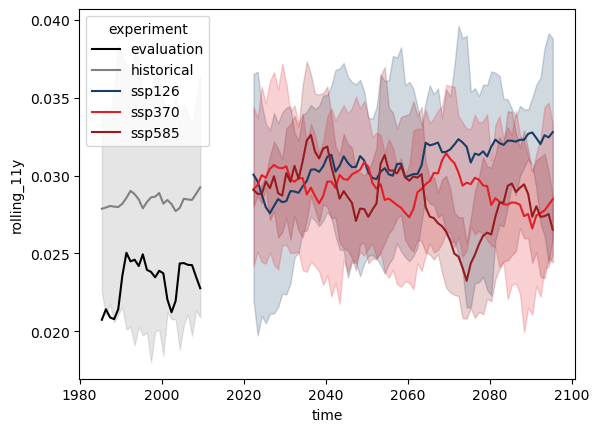

In [69]:
sns.lineplot(df_jja, x="time", y="rolling_11y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

<Axes: xlabel='time', ylabel='rolling_21y'>

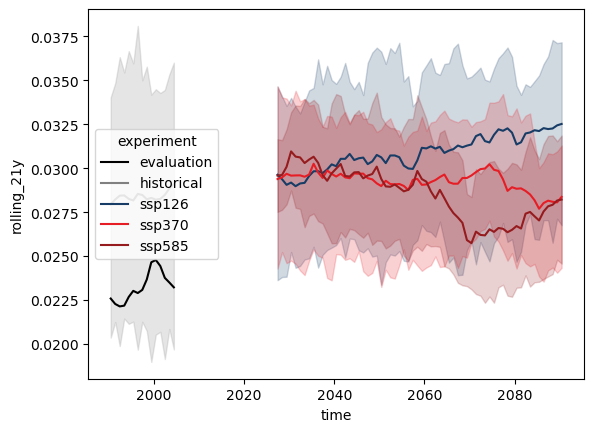

In [70]:
sns.lineplot(df_jja, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

In [71]:
var =  "freq_above_p99_windspeed"
df = ds_results.to_dataframe()[var].reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]

df_djf = df.loc[df.time.dt.month.isin([12, 1, 2])]

window_size = 5
df_djf[ f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()

window_size = 11
df_djf[f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()

window_size = 21
df_djf[f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()

df_djf



/jobfs/149558643.gadi-pbs/ipykernel_702242/1860841327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_djf[ f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/1860841327.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_djf[f"rolling_{window_size}y"] = df_djf[var].rolling(window=window_size, center=True).mean()
/jobfs/149558643.gadi-pbs/ipykernel_702242/1860841327.py:14: SettingWithCopyWarning: 
A value is trying to

run       time  freq_above_p99_windspeed  \
3      evaluation_ERA5_r1i1p1f1 1980-12-01                  0.003526   
7      evaluation_ERA5_r1i1p1f1 1981-12-01                  0.009923   
11     evaluation_ERA5_r1i1p1f1 1982-12-01                  0.004086   
15     evaluation_ERA5_r1i1p1f1 1983-12-01                  0.003858   
19     evaluation_ERA5_r1i1p1f1 1984-12-01                  0.002658   
...                         ...        ...                       ...   
9503  ssp585_EC-Earth3_r1i1p1f1 2096-12-01                  0.008161   
9507  ssp585_EC-Earth3_r1i1p1f1 2097-12-01                  0.010011   
9511  ssp585_EC-Earth3_r1i1p1f1 2098-12-01                  0.004211   
9515  ssp585_EC-Earth3_r1i1p1f1 2099-12-01                  0.014322   
9519  ssp585_EC-Earth3_r1i1p1f1 2100-12-01                  0.002221   

      experiment  rolling_5y  rolling_11y  rolling_21y  
3     evaluation         NaN          NaN          NaN  
7     evaluation         NaN          NaN          NaN  
11    evaluation    0.004810          NaN          NaN  
15    evaluation    0.004303          NaN          NaN  
19    evaluation    0.002911          NaN          NaN  
...          ...         ...          ...          ...  
9503      ssp585    0.009045          NaN          NaN  
9507      ssp585    0.009006          NaN          NaN  
9511      ssp585    0.007785          NaN          NaN  
9515      ssp585         NaN          NaN          NaN  
9519      ssp585         NaN          NaN          NaN  

[2380 rows x 7 columns]

<Axes: xlabel='time', ylabel='freq_above_p99_windspeed'>

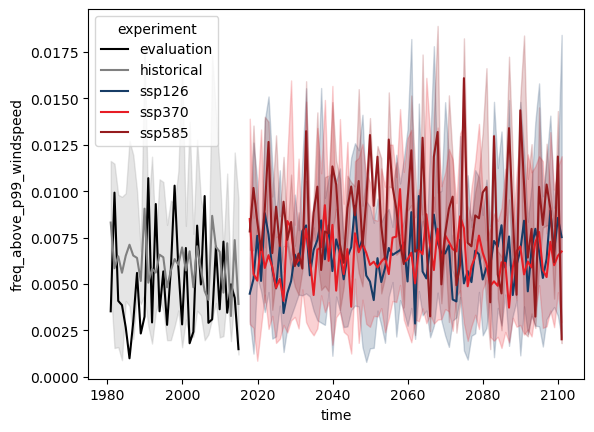

In [81]:
sns.lineplot(df_djf, x="time", y=var, hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

<Axes: xlabel='time', ylabel='rolling_11y'>

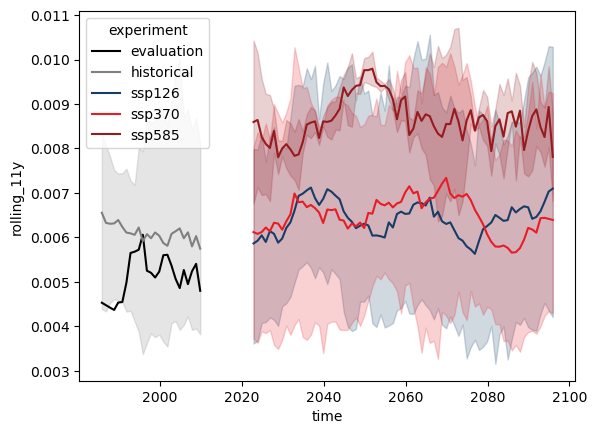

In [77]:
sns.lineplot(df_djf, x="time", y="rolling_11y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)


<Axes: xlabel='time', ylabel='rolling_21y'>

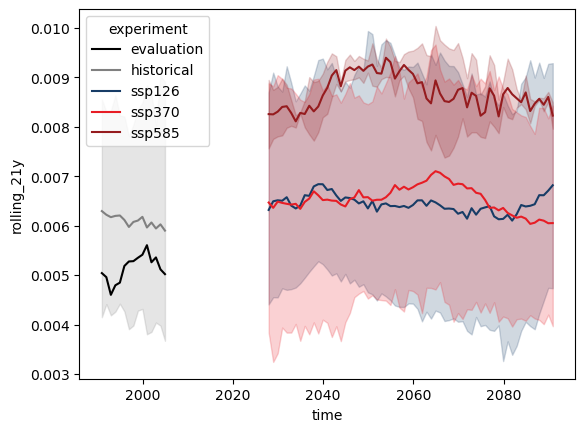

In [80]:
sns.lineplot(df_djf, x="time", y="rolling_21y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)


In [13]:
//

SyntaxError: invalid syntax (411536581.py, line 1)

In [ ]:
list_ssp126 = ['ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

In [ ]:
xr.plot.line(ds_results.sel({"run": list(i_evaluation)})["windspeed"], x="time", hue="run", figsize=(12,12), color="k" );
xr.plot.line(ds_results.sel({"run": list(i_historical)})["windspeed"], x="time", hue="run", color="grey",  );
xr.plot.line(ds_results.sel({"run": list_ssp126[1:]})["windspeed"], x="time", hue="run", color="blue",  );
xr.plot.line(ds_results.sel({"run": list_ssp370})["windspeed"], x="time", hue="run", color="orange",  );
xr.plot.line(ds_results.sel({"run": list_ssp585})["windspeed"], x="time", hue="run", color="r",  );

In [ ]:
/

In [ ]:
ds_results.to_netcdf("/scratch/v46/gt3409/timeseries_windspeed_sog_p99_season.nc")

In [ ]:
ds_results = xr.open_dataset("/scratch/v46/gt3409/timeseries_windspeed_sog_p99_season.nc")

In [ ]:
list_ssp126 = ['ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

In [ ]:
xr.plot.line(ds_results.sel({"run": list(i_evaluation)})["windspeed"], x="time", hue="run", figsize=(12,12), color="k" );
xr.plot.line(ds_results.sel({"run": list(i_historical)})["windspeed"], x="time", hue="run", color="grey",  );
xr.plot.line(ds_results.sel({"run": list_ssp126[1:]})["windspeed"], x="time", hue="run", color="blue",  );
xr.plot.line(ds_results.sel({"run": list_ssp370})["windspeed"], x="time", hue="run", color="orange",  );
xr.plot.line(ds_results.sel({"run": list_ssp585})["windspeed"], x="time", hue="run", color="r",  );

In [ ]:
/\